<a href="https://colab.research.google.com/github/MatthieuDlhy/supervised_learning_project/blob/main/Final_project_supervised_learning_DELAHAYE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing the libraries

import numpy as np 
import pandas as pd 

from tensorflow import keras
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,Flatten
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
# Construct a tf.data.Dataset
ds, info = tfds.load('colorectal_histology', split='train', with_info=True, as_supervised=True, shuffle_files=True)
ds = ds.map(lambda img, lbl: (tf.cast(img, tf.float32) / 255.0, lbl))                                                  # we keep only the image and the labels for our analysis / we rescale the dataset between 0 and 1
#read the dataset into a tensorflow styled_dataframe
df = tfds.as_dataframe(ds, info)
#save the dataframe into csv file
df.to_csv("colorectal_histology.csv", index=False)

In [ ]:
ds

In [ ]:
#read the csv file as normal, then you have the df you need
import pandas as pd
file_path = "colorectal_histology.csv"
df = pd.read_csv(file_path, header = 0, sep=",")
df

,image,label
0,[[[0.6784314 0.32156864 0.44313726]\n [0.729...,4
1,[[[0.41568628 0.18431373 0.34117648]\n [0.501...,5
2,[[[0.4627451 0.2 0.4 ]\n [0.478...,5
3,[[[0.39215687 0.23529412 0.4745098 ]\n [0.423...,0
4,[[[0.94509804 0.9529412 0.9411765 ]\n [0.945...,6
...,...,...
4995,[[[0.9607843 0.96862745 0.95686275]\n [0.960...,7
4996,[[[0.7019608 0.36862746 0.52156866]\n [0.705...,1
4997,[[[0.1882353 0.12156863 0.25490198]\n [0.152...,5
4998,[[[0.89411765 0.8666667 0.89411765]\n [0.847...,4


### Splitting the data  
We will take 60% for training, 20% for validation and 20% for testing.

In [ ]:
valid_data = ds.take(1000)

test_data = ds.skip(1000).take(1000)

train_data = ds.skip(2000).take(3000)

### Distribution of data

In [ ]:
# Creation of pandas dataframe for the train, test and valid sets

# Train

df_train_data = tfds.as_dataframe(train_data, info)
#save the dataframe into csv file
df_train_data.to_csv("df_train_data.csv", index=False)

#read the csv file as normal to obtain our dataframe
file_path = "df_train_data.csv"
df_train_data = pd.read_csv(file_path, header = 0, sep=",")

# Valid

df_valid_data = tfds.as_dataframe(valid_data, info)
#save the dataframe into csv file
df_valid_data.to_csv("df_valid_data.csv", index=False)

#read the csv file as normal to obtain our dataframe
file_path = "df_valid_data.csv"
df_valid_data = pd.read_csv(file_path, header = 0, sep=",")

# Test

df_test_data = tfds.as_dataframe(test_data, info)
#save the dataframe into csv file
df_test_data.to_csv("df_test_data.csv", index=False)

#read the csv file as normal to obtain our dataframe
file_path = "df_test_data.csv"
df_test_data = pd.read_csv(file_path, header = 0, sep=",")

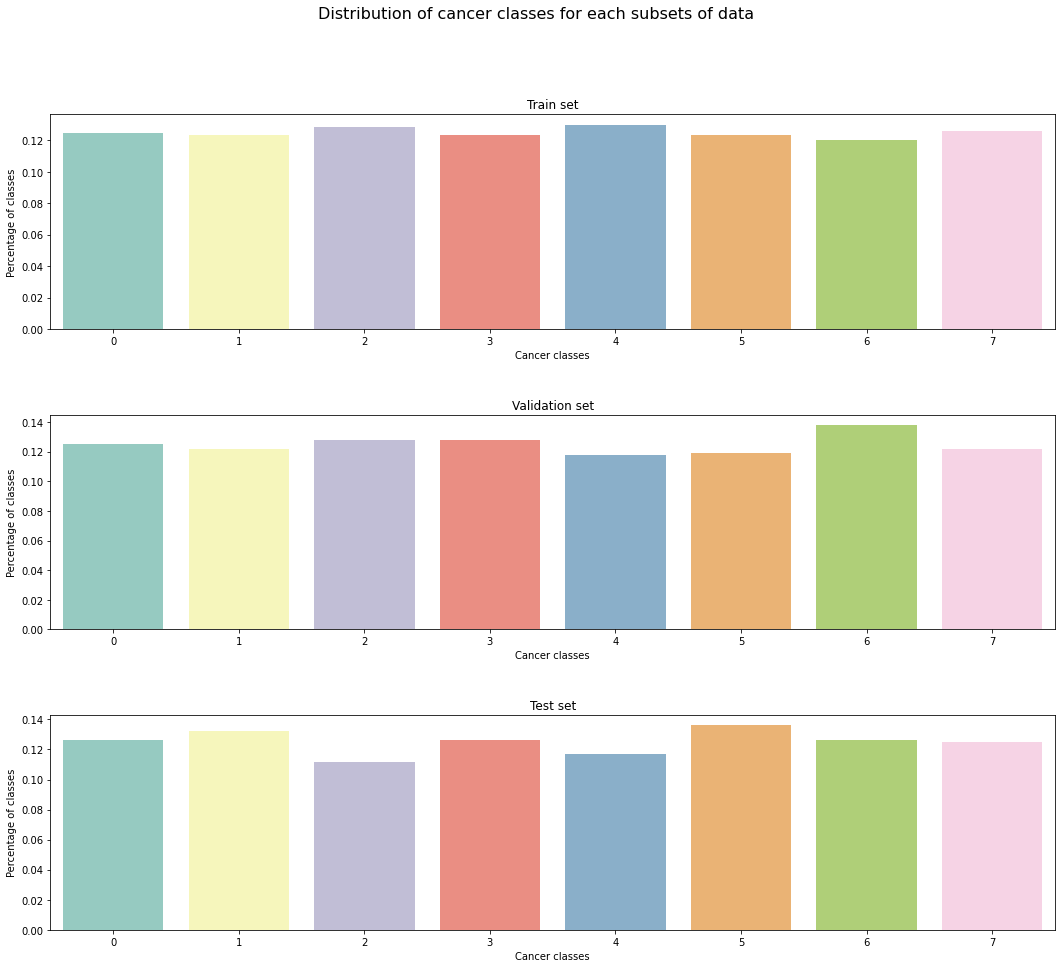

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(18,15))
fig.suptitle("Distribution of cancer classes for each subsets of data", fontsize=16)

# compute the distribution for each set
train_label_percentage = df_train_data.label.value_counts() / df_train_data.shape[0]
test_label_percentage = df_test_data.label.value_counts() / df_test_data.shape[0]
valid_label_percentage = df_valid_data.label.value_counts() / df_valid_data.shape[0]

# plot train
sns.barplot(ax=ax1, x=train_label_percentage.index, y=train_label_percentage.values, palette="Set3")
ax1.set_title("Train set")
ax1.set_xlabel("Cancer classes")
ax1.set_ylabel("Percentage of classes")

# plot valid
sns.barplot(ax=ax2, x=valid_label_percentage.index, y=valid_label_percentage.values, palette="Set3")
ax2.set_title("Validation set")
ax2.set_xlabel("Cancer classes")
ax2.set_ylabel("Percentage of classes")

# plot test
sns.barplot(ax=ax3, x=test_label_percentage.index, y=test_label_percentage.values, palette="Set3")
ax3.set_title("Test set")
ax3.set_xlabel("Cancer classes")
ax3.set_ylabel("Percentage of classes")

fig.subplots_adjust(hspace=0.4)

Classes are pretty well distributed in each set, there are no "dominant" classes. So, we can pursue our analysis.

### Batching data

In [ ]:
batch_size = 64

valid_data = valid_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = test_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_data = train_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

# TODO: explain cache(), batch() and prefetch functions

### Build the model

In [8]:
import tensorflow as tf
model = tf.keras.Sequential([
        tf.keras.layers.InputLayer((150, 150, 3)),
        tf.keras.layers.Conv2D(64, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, activation=tf.keras.activations.relu),  #on met 4 conv2d ain de baisser la taille de l'image au minimum pour pouvoir conncté une flatten de 512 neuronnes conncté à 2 dense divisant par 2 le nb de neuronnes et finir sur la dense qui fera correspondre les classes (softmax)
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(8, activation=tf.keras.activations.softmax)
    ])

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=['accuracy'])

In [10]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 17, 17, 128)     

### Train

In [ ]:
# train the model
epochs = 100
history = model.fit(train_data, validation_data=valid_data, epochs=epochs)

Epoch 1/100
47/47 [==============================] - 9s 108ms/step - loss: 1.7732 - accuracy: 0.2247 - val_loss: 1.4086 - val_accuracy: 0.3310
Epoch 2/100
47/47 [==============================] - 4s 79ms/step - loss: 1.2797 - accuracy: 0.4233 - val_loss: 1.0821 - val_accuracy: 0.4990
Epoch 3/100
47/47 [==============================] - 4s 79ms/step - loss: 0.9952 - accuracy: 0.5630 - val_loss: 0.8773 - val_accuracy: 0.6170
Epoch 4/100
47/47 [==============================] - 4s 80ms/step - loss: 0.9342 - accuracy: 0.5993 - val_loss: 0.9006 - val_accuracy: 0.5730
Epoch 5/100
47/47 [==============================] - 4s 79ms/step - loss: 0.9401 - accuracy: 0.5847 - val_loss: 0.8752 - val_accuracy: 0.6290
Epoch 6/100
47/47 [==============================] - 4s 80ms/step - loss: 0.8619 - accuracy: 0.6413 - val_loss: 0.7989 - val_accuracy: 0.6770
Epoch 7/100
47/47 [==============================] - 4s 80ms/step - loss: 0.8433 - accuracy: 0.6620 - val_loss: 0.7728 - val_accuracy: 0.6890
Epoch

### Curves

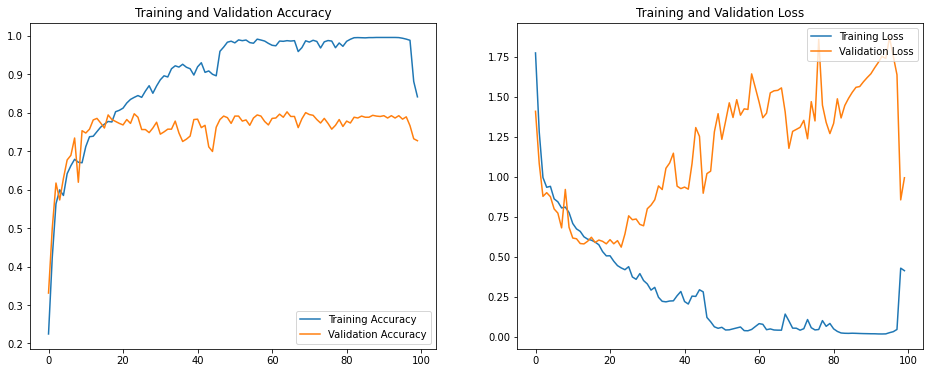

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print(model.evaluate(test_data))

### Overfitting

The model is a little bit overfitting, to counter that we can use:


*   Data Augmentation
*   Dropout layer




### Dropout

In [ ]:
model2 = tf.keras.Sequential([
        tf.keras.layers.InputLayer((150, 150, 3)),
        tf.keras.layers.Conv2D(64, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.AveragePooling2D(),
        tf.keras.layers.Conv2D(128, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, activation=tf.keras.activations.relu),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),   # 20% of drop
        tf.keras.layers.Dense(256, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(8, activation=tf.keras.activations.softmax)
    ])

In [ ]:
model2.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 average_pooling2d_2 (Averag  (None, 17, 17, 128)     

### Callbacks

In [ ]:
import math

checkpoint = tf.keras.callbacks.ModelCheckpoint('the_best_model.h5', # You also can provide full path to the folder you want to save your model to
    monitor='val_loss',  # Monitor other things like val_accuracy or accuracy 
    save_best_only='True', # Make sure to save only the best model
    verbose=1)

earlystop = tf.keras.callbacks.EarlyStopping('val_loss',
                                             patience=20,
                                             restore_best_weights=True)

# tensor_board = tf.keras.callbacks.TensorBoard('./tb_logs/run_logs')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

# initial_learning_rate = 0.01
# decay = initial_learning_rate / epochs

# def lr_time_based_decay(epoch, lr):
#     return lr * 1 / (1 + decay * epoch)

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     # lambda epoch: 1e-2 * 10**(epoch/20)
#     lr_time_based_decay
# )

In [ ]:
# train the model
epochs = 200
history2 = model2.fit(train_data,
                      validation_data=valid_data,
                      epochs=epochs,
                      callbacks=[earlystop, checkpoint, reduce_lr])

Epoch 1/200
47/47 [==============================] - ETA: 0s - loss: 1.6932 - accuracy: 0.2577
Epoch 1: val_loss improved from inf to 1.37606, saving model to the_best_model.h5
47/47 [==============================] - 6s 95ms/step - loss: 1.6932 - accuracy: 0.2577 - val_loss: 1.3761 - val_accuracy: 0.3760 - lr: 0.0010
Epoch 2/200
47/47 [==============================] - ETA: 0s - loss: 1.2361 - accuracy: 0.4490
Epoch 2: val_loss improved from 1.37606 to 1.07004, saving model to the_best_model.h5
47/47 [==============================] - 4s 82ms/step - loss: 1.2361 - accuracy: 0.4490 - val_loss: 1.0700 - val_accuracy: 0.5430 - lr: 0.0010
Epoch 3/200
47/47 [==============================] - ETA: 0s - loss: 1.1285 - accuracy: 0.4837
Epoch 3: val_loss improved from 1.07004 to 1.01005, saving model to the_best_model.h5
47/47 [==============================] - 4s 82ms/step - loss: 1.1285 - accuracy: 0.4837 - val_loss: 1.0101 - val_accuracy: 0.5520 - lr: 0.0010
Epoch 4/200
47/47 [=============

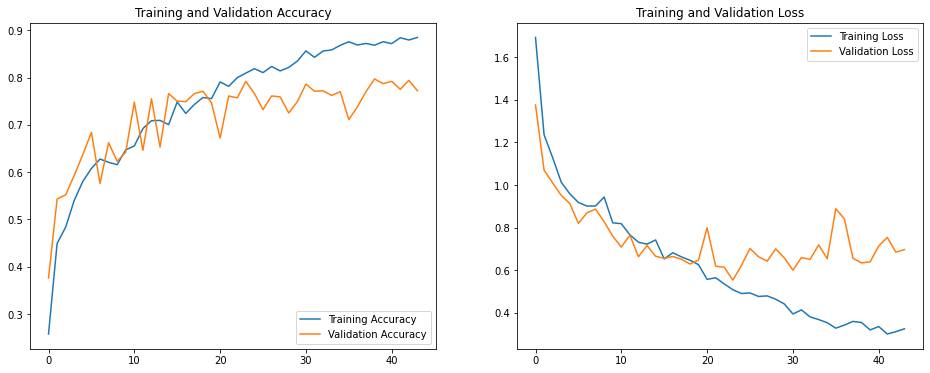

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(44)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Testing accuracy on the test set

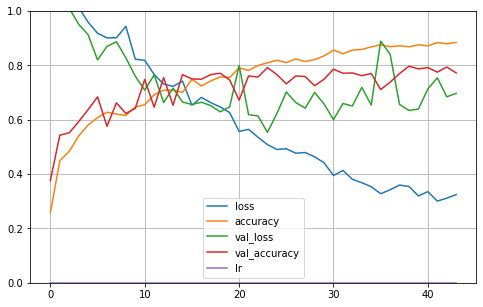

16/16 [==============================] - 1s 34ms/step - loss: 0.8800 - accuracy: 0.7630
[0.8799708485603333, 0.7630000114440918]


In [ ]:
print(model2.evaluate(test_data))

Sources:
https://medium.com/@ashraf.dasa/tensorflow-image-classification-of-colorectal-cancer-histology-92-5-accuracy-8b8b40ac775a